In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import mols2grid

from rdkit import Chem

from src.utils import smi2mol
from src.config import mem
from mordred import Calculator, descriptors

train = pd.read_csv('../data/processed/train.csv', index_col=0)

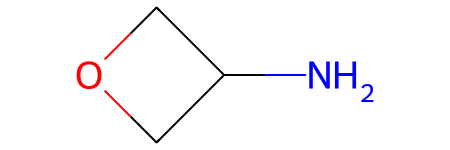

In [3]:
mol = smi2mol('NC1COC1')
mol

In [4]:
from src.fingerprints import get_fingerprints
from src.descriptors import get_rd_descriptors, get_md_descriptors
from src.representation import get_representation, get_representation_from_series

In [5]:
get_fingerprints(mol)

[13:53:04] DEPRECATION WARNING: please use MorganGenerator


0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
2358    0.0
2359    0.0
2360    0.0
2361    0.0
2362    0.0
Length: 2363, dtype: float64

In [6]:
get_rd_descriptors(mol)

[13:53:04] DEPRECATION WARNING: please use MorganGenerator
[13:53:04] DEPRECATION WARNING: please use MorganGenerator
[13:53:04] DEPRECATION WARNING: please use MorganGenerator


rd_BalabanJ             2.079672
rd_BertzCT             33.874303
rd_Chi0                 3.698671
rd_Chi0n                2.977162
rd_Chi0v                2.977162
                         ...    
rd_fr_thiocyan          0.000000
rd_fr_thiophene         0.000000
rd_fr_unbrch_alkane     0.000000
rd_fr_urea              0.000000
rd_qed                  0.413038
Length: 200, dtype: float64

In [7]:
get_md_descriptors(mol)

md_ABC               NaN
md_ABCGG             NaN
md_nAcid        0.000000
md_nBase        1.000000
md_SpAbs_A      5.595865
                 ...    
md_WPol         1.000000
md_Zagreb1     22.000000
md_Zagreb2     23.000000
md_mZagreb1     1.861111
md_mZagreb2     1.166667
Length: 1826, dtype: float64

In [8]:
#X = train.smi.apply(get_representation)

In [9]:
# from src.utils import apply_mp
# 
# X_mp = apply_mp(train.smi, get_representation)

In [10]:
X = mem.cache(get_representation_from_series, ignore=['n_jobs'])(train.smi, n_jobs=24)
X.shape

(7939, 4389)

In [11]:
def drop_nans_non_unique(df):
    df.dropna(axis=1, inplace=True)
    df = df.loc[:, df.nunique() > 1].copy()
    return df

# add gin descriptors

In [12]:
from molfeat.trans.pretrained import PretrainedDGLTransformer
transformer = PretrainedDGLTransformer(kind='gin_supervised_masking', dtype=float)

res = mem.cache(transformer)(train.smi)
cols = ['gin_' + str(i) for i in range(res.shape[1])]

gin_feats = pd.DataFrame(res, columns=cols, index=train.smi.index)

In [13]:
X = pd.concat([X, gin_feats], axis=1)

In [14]:
# X.dropna(axis=1, inplace=True)
# X.shape

In [15]:
# (X.nunique() == 1).sum()

In [16]:
# X = X.loc[:, X.nunique() > 1]
# X.shape

In [17]:
# from src.utils import get_fps_offset

# FPS_SIZE = get_fps_offset(X.columns)

In [18]:
# (X.iloc[:, FPS_SIZE:] == 0).all().sum()

In [19]:
# X.columns[FPS_SIZE:]

### split dataset

In [20]:
ids_1 = train[train.prop == 1].index
ids_2 = train[train.prop == 2].index
ids_3 = train[train.prop == 3].index

In [21]:
X_train_1 = X.loc[ids_1]
X_train_2 = X.loc[ids_2]
X_train_3 = X.loc[ids_3]

In [22]:
X_train_1 = drop_nans_non_unique(X_train_1)
X_train_2 = drop_nans_non_unique(X_train_2)
X_train_3 = drop_nans_non_unique(X_train_3)

In [23]:
# X_train_1.to_csv('../data/interim/X_train_1.csv.zip')
# X_train_2.to_csv('../data/interim/X_train_2.csv.zip')
# X_train_3.to_csv('../data/interim/X_train_3.csv.zip')

X_train_1.to_pickle('../data/processed/X_train_1.pkl.zip')
X_train_2.to_pickle('../data/processed/X_train_2.pkl.zip')
X_train_3.to_pickle('../data/processed/X_train_3.pkl.zip')

In [24]:
y_train_1 = train[train.prop == 1].target
y_train_2 = train[train.prop == 2].target
y_train_3 = train[train.prop == 3].target

In [25]:
# y_train_1.to_csv('../data/processed/y_train_1.csv')
# y_train_2.to_csv('../data/processed/y_train_2.csv')
# y_train_3.to_csv('../data/processed/y_train_3.csv')

y_train_1.to_pickle('../data/processed/y_train_1.pkl')
y_train_2.to_pickle('../data/processed/y_train_2.pkl')
y_train_3.to_pickle('../data/processed/y_train_3.pkl')

In [26]:
X_train_1.shape, X_train_2.shape, X_train_3.shape

((5094, 3756), (1424, 4112), (1421, 3834))

In [27]:
y_train_1.shape, y_train_2.shape, y_train_3.shape

((5094,), (1424,), (1421,))

# Test set

In [28]:
test = pd.read_csv('../data/processed/test.csv', index_col=0)

In [29]:
X_test = mem.cache(get_representation_from_series, ignore=['n_jobs'])(test.smi, n_jobs=24)

res = mem.cache(transformer)(test.smi)
cols = ['gin_' + str(i) for i in range(res.shape[1])]

gin_feats = pd.DataFrame(res, columns=cols, index=test.smi.index)

X_test = pd.concat([X_test, gin_feats], axis=1)

In [30]:
X_test.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       'gin_290', 'gin_291', 'gin_292', 'gin_293', 'gin_294', 'gin_295',
       'gin_296', 'gin_297', 'gin_298', 'gin_299'],
      dtype='object', length=4689)

In [31]:
# X_test = X_test[X.columns]
# X_test.shape

In [32]:
ids_1 = test[test.prop == 1].index
ids_2 = test[test.prop == 2].index
ids_3 = test[test.prop == 3].index

In [33]:
X_test_1 = X_test.loc[ids_1]
X_test_2 = X_test.loc[ids_2]
X_test_3 = X_test.loc[ids_3]

In [34]:
# X_test_1 = X_test_1[X_train_1.columns]
# X_test_2 = X_test_2[X_train_2.columns]
# X_test_3 = X_test_3[X_train_3.columns]

In [35]:
# X_test_1.to_csv('../data/interim/X_test_1.csv')
# X_test_2.to_csv('../data/interim/X_test_2.csv')
# X_test_3.to_csv('../data/interim/X_test_3.csv')

X_test_1.to_pickle('../data/processed/X_test_1.pkl.zip')
X_test_2.to_pickle('../data/processed/X_test_2.pkl.zip')
X_test_3.to_pickle('../data/processed/X_test_3.pkl.zip')

In [36]:
X_test_1.shape, X_test_2.shape, X_test_3.shape

((408, 4689), (407, 4689), (406, 4689))